testsupを特徴量の抽出に使用

In [7]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import pickle

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
        df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
        df['minute'] = dt.minute.astype('uint8')
#         df['second'] = dt.second.astype('uint8')#secondを追加

        del(dt)
        
        df_add_counts(df, ['ip'])
        df_add_counts(df, ['ip','day','hour','minute'])
#         df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'day', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def make_next_click_feature(df):
    with timer("Adding next click times"):
        D= 2**26
        df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
                         + "_" + df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-time)
            click_buffer[category]= time
        del(click_buffer)
        df['next_click']= list(reversed(next_clicks))
        
path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [5]:
with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv", skiprows=range(1,104903891), nrows=80000000, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)

[load training data] done in 127 s


In [8]:
with open('test.csv.pkl', 'rb') as f:
  test_df = pickle.load(f)
  print(test_df.head())
    
with open('testsup_without_test.csv.pkl', 'rb') as f:
  testsup_df = pickle.load(f)
  print(testsup_df.head())

   click_id      ip  app  device  os  channel           click_time
0         0    5744    9       1   3      107  2017-11-10 04:00:00
1         1  119901    9       1   3      466  2017-11-10 04:00:00
2         2   72287   21       1  19      128  2017-11-10 04:00:00
3         3   78477   15       1  13      111  2017-11-10 04:00:00
4         4  123080   12       1  13      328  2017-11-10 04:00:00
   click_id      ip  app  device  os  channel           click_time  \
0         0   43570    3       1  18      379  2017-11-09 14:23:39   
1         1   80528    3       1  13      379  2017-11-09 14:23:51   
2         2   32323    3       1  13      379  2017-11-09 14:25:57   
3         3   42887    3       1  17      379  2017-11-09 14:26:03   
4         4  119289   58       1  30      120  2017-11-09 14:26:41   

   click_id.test  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


In [11]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [10]:
testsup_df = testsup_df.drop("click_id.test", axis=1)
testsup_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,43570,3,1,18,379,2017-11-09 14:23:39
1,1,80528,3,1,13,379,2017-11-09 14:23:51
2,2,32323,3,1,13,379,2017-11-09 14:25:57
3,3,42887,3,1,17,379,2017-11-09 14:26:03
4,4,119289,58,1,30,120,2017-11-09 14:26:41


In [4]:
# testsup_ip_max = testsup_df.ip.max()
# train_df = train_df[train_df.ip <= testsup_ip_max]
# print(len(train_df.index))
# print(train_df.ip.max())

36085903
126411


In [12]:
num_train = train_df.shape[0]
y = train_df.is_attributed.values

sub = pd.DataFrame()
sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],test_df[common_column],testsup_df[common_column]])

del train_df, testsup_df, test_df
gc.collect()

1492

In [13]:
make_count_features(concat_df)
make_next_click_feature(concat_df)

gc.collect()

[add count features] done in 623 s
[Adding next click times] done in 977 s


28

In [14]:
with open('test.csv.pkl', 'rb') as f:
  test_df = pickle.load(f)
  print(test_df.head())

num_test = test_df.shape[0]
print(num_test)
del test_df

   click_id      ip  app  device  os  channel           click_time
0         0    5744    9       1   3      107  2017-11-10 04:00:00
1         1  119901    9       1   3      466  2017-11-10 04:00:00
2         2   72287   21       1  19      128  2017-11-10 04:00:00
3         3   78477   15       1  13      111  2017-11-10 04:00:00
4         4  123080   12       1  13      328  2017-11-10 04:00:00
18790469


In [15]:
train_df = concat_df.iloc[:num_train]
test_sup_df = concat_df.iloc[num_train:]
test_df = test_sup_df.iloc[:num_test]
# testsup_df = test_sup_df.iloc[:num_test]

del concat_df, test_sup_df

print(test_df.head())
# print(testsup_df.head())

gc.collect()

       ip  app  device  os  channel          click_time  day  hour  minute  \
0    5744    9       1   3      107 2017-11-10 04:00:00   10     4       0   
1  119901    9       1   3      466 2017-11-10 04:00:00   10     4       0   
2   72287   21       1  19      128 2017-11-10 04:00:00   10     4       0   
3   78477   15       1  13      111 2017-11-10 04:00:00   10     4       0   
4  123080   12       1  13      328 2017-11-10 04:00:00   10     4       0   

   ip_count  ip_day_hour_minute_count  os_app_channel_count  \
0       827                         2                 34114   
1     15131                        15                 45300   
2     10457                         5                454989   
3      7985                         9                 92942   
4      1063                         4                302318   

   ip_day_hour_count  ip_app_count  ip_app_os_count  ip_device_count  \
0                 34           191                7              781   
1       

266

In [16]:
train_df, val_df, y_train, y_val = train_test_split(train_df, y, train_size=0.8, shuffle=False)#trainを0.8、シャッフルfalseにした

evals_results = {}
num_boost_round = 250
early_stopping_rounds = 30

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99
}
# metrics = 'auc'
# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': metrics,
#     'learning_rate': .1,
#     'num_leaves': 7,
#     'max_depth': 4,
#     'min_child_samples': 100,
#     'max_bin': 100,
#     'subsample': 0.7,
#     'subsample_freq': 1,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 0,
#     'min_split_gain': 0,
#     'nthread': 4,
#     'verbose': 1,
#     'scale_pos_weight': 99.7
#     #'scale_pos_weight': 400
# }

In [18]:
target = "is_attributed"
categorical = ['app','os','channel','device']
predictors = list(set(train_df.columns)-set([target])-set(['click_time','category','epochtime','minute','ip']))
print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(train_df[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del train_df
del y_train
gc.collect()

xgvalid = lgb.Dataset(val_df[predictors].values,
                      label=y_val,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del val_df
del y_val
gc.collect()

['ip_day_hour_count', 'day', 'ip_count', 'ip_day_hour_minute_count', 'ip_device_count', 'hour', 'app', 'ip_app_count', 'os_app_channel_count', 'app_channel_count', 'ip_app_os_count', 'os', 'channel', 'device', 'next_click']
preparing validation datasets


25

In [19]:
booster = lgb.train(
     lgb_params, 
     xgtrain,
     valid_sets=[xgvalid],
     valid_names=['valid'],
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

# n_estimators = model.best_iteration

# print('\nModel Info:')
# print('n_estimators:', n_estimators)
# print(metrics+':', evals_results['valid'][metrics][n_estimators-1])

del xgvalid
del xgtrain
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid's auc: 0.952476
Training until validation scores don't improve for 30 rounds.
[2]	valid's auc: 0.953777
[3]	valid's auc: 0.959285
[4]	valid's auc: 0.959953
[5]	valid's auc: 0.959933
[6]	valid's auc: 0.960514
[7]	valid's auc: 0.964626
[8]	valid's auc: 0.964729
[9]	valid's auc: 0.965033
[10]	valid's auc: 0.965238
[11]	valid's auc: 0.966925
[12]	valid's auc: 0.967071
[13]	valid's auc: 0.968001
[14]	valid's auc: 0.968264
[15]	valid's auc: 0.968496
[16]	valid's auc: 0.968651
[17]	valid's auc: 0.969338
[18]	valid's auc: 0.969479
[19]	valid's auc: 0.969592
[20]	valid's auc: 0.971074
[21]	valid's auc: 0.971623
[22]	valid's auc: 0.972162
[23]	valid's auc: 0.972578
[24]	valid's auc: 0.973116
[25]	valid's auc: 0.974011
[26]	valid's auc: 0.9743
[27]	valid's auc: 0.974833
[28]	valid's auc: 0.975235
[29]	valid's auc: 0.975613
[30]	valid's auc: 0.975897
[31]	valid's auc: 0.976593
[32]	valid's auc: 0.976778
[33]	valid's auc: 0.977083
[34]	valid's auc: 0.977576
[35]	valid's auc: 0.978153
[36]

32

[250]	valid's auc: 0.985319
Did not meet early stopping. Best iteration is:
[231]	valid's auc: 0.985328

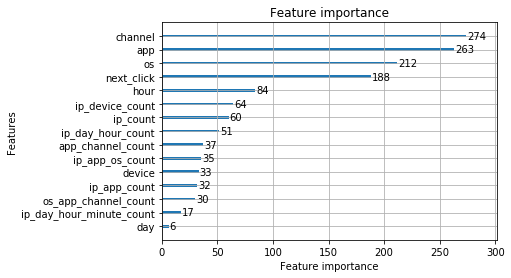

In [21]:
import matplotlib.pyplot as plt
ax = lgb.plot_importance(booster, max_num_features=100)
# plt.savefig('04301-3imp.png', dpi=600, bbox_inches='tight')
plt.show()

In [22]:
preditions=booster.predict(test_df[predictors].values)

In [23]:
sub['is_attributed']  = preditions

sub.to_csv('04301-3sub.csv', float_format='%.8f', index=False)